# Part 2: MOSAIKS
To predict the relative wealth of the people in a given area, we will start with a geospatial foundation model called MOSAIKS. MOSAIKS uses random convolutional features to extract n features from a satellite image, each corresponding to a given random filter. 

MULTI-TASK OBSERVATION USING SATELLITE IMAGERY & KITCHEN SINKS
Nature Paper: https://www.nature.com/articles/s41467-021-24638-z
Website with API: https://api.mosaiks.org/portal/index/

## Environment Setup

In [ ]:
# install any libraries that are missing
# !pip install geopandas
# !pip install lonboard

In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from lonboard import viz

# set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("imported")


imported


In [109]:
# configure parameters
decimal_place = 0.25 # spatial resolution of the mosaiks embeddings in degrees of lat/long
base_path = f"/Users/isaiah/code/ai4good/data/wk5/mosaiks{decimal_place}/"
zip_path = f"{base_path}global_{decimal_place}.zip"
mosaiks_embeddings_path = f"{base_path}coarsened_global_dense_grid_decimal_place={decimal_place}_GHS_pop_weight=True.csv"
labels_path = f"{base_path}dhs_final_labels_centered.csv"
merge_path = f"{base_path}dhs_final_labels_centered_with_mosaiks.csv"

In [ ]:
import os
import requests
from tqdm import tqdm

# which data resolution you want as a fraction of a degree
# use 0 for 1 degree or 0.25 for 1/4 degree
decimal_place = 0.25

# Cookie for authentication
COOKIE = {
    "csrftoken": "I9x2jvGGE4se3MBa9moavDtC9o8YEgaA4Rup5ijhHJjCTRn0qRpHGJW06XG0SooG",
    "sessionid": "y44nlmh7rjrqvvxj902jc8pmw918m1p7",
}


# Destination directory
os.makedirs(base_path, exist_ok=True)  # Ensure the directory exists

# Function to download a file with progress bar
def download_file(url, filename):
    response = requests.get(url, cookies=COOKIE, stream=True, verify=False)
    # handle request
    if response.status_code == 200:
        total_size = int(response.headers.get("content-length", 0))
        with open(filename, "wb") as f, tqdm(
            desc=os.path.basename(filename),
            total=total_size,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(1024):
                f.write(chunk)
                bar.update(len(chunk))
        print(f"✅ Downloaded: {filename}")
    else:
        print(f"❌ Failed to download {url} (Status {response.status_code})")

# Download each file
# Base URL for file downloads
URL = f"https://api.mosaiks.org/portal/download_grid_file/coarsened_global_dense_grid_decimal_place=0.25_GHS_pop_weight=True.zip"
print(f"📥 Downloading {URL}...")
download_file(URL, zip_path)

In [ ]:
# unzip the files
import zipfile
import os
import glob

decimal_place = 0.25

# Define the directory containing the zip files
path = f"/Users/isaiah/code/ai4good/data/wk5/mosaiks{decimal_place}"
# Loop through all zip files in the directory
for zip_file in glob.glob(os.path.join(path, "*.zip")):
    # Open the zip file
    with zipfile.ZipFile(zip_file, "r") as z:
        # Extract all the contents into the extraction directory
        z.extractall(path)
        print(f"Extracted {zip_file} to {path}")

### Prepare Data to Merge with MOSAIKS Embeddings
Now we need to match up our locations with the MOSAIKS locations.

In [107]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/Users/isaiah/code/ai4good/data/wk5/dhs_final_labels.csv")

# Assign coordinates to nearest tile centroid

# for 1 degree
if decimal_place == 0:
    df["Lon"] = round(round(df["lon"] + 0.5, 0) - 0.5, 1)
    df["Lat"] = round(round(df["lat"] + 0.5, 0) - 0.5, 1)
# for 1/4 degree
if decimal_place == 0.25:
    df["Lon"] = round((round(df["lon"]*4 + 0.5, 0) - 0.5)/4, 3)
    df["Lat"] = round((round(df["lat"]*4 + 0.5, 0) - 0.5)/4, 3)

# drop rows that have a NaN for asset_index
df = df.dropna(subset=["asset_index"])

# keep just one row for every unique Lat, Lon combination
before_len = len(df)
df = df.drop_duplicates(subset=["Lat", "Lon"], keep="first")
print(f"Started with {before_len} rows, now have {len(df)} rows")

# Convert to GeoDataFrame
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Lon"], df["Lat"]), crs="EPSG:4326")

# Write to CSV
df_gdf.to_csv(f"/Users/isaiah/code/ai4good/data/wk5/mosaiks{decimal_place}/dhs_final_labels_centered.csv", index=False)

# visualize it, it should appear gridded to 1 degree now
viz(df_gdf)

Started with 86936 rows, now have 15725 rows


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

### Merge Embeddings with Labels
Now that the data points have been moved to the centroids of the clusters, we can merge the embeddings with the labels.

In [108]:
# read in the MOSAIKS embeddings
mosaiks = pd.read_csv(mosaiks_embeddings_path)
df = pd.read_csv(labels_path)

# merge the two dataframes on the Lat, Lon columns from the labels and the lat, lon columns from the mosaiks
mosaiks = mosaiks.rename(columns={"lat": "Lat", "lon": "Lon"})
df_merged = df.merge(mosaiks, on=["Lat", "Lon"], how="left")

# save this as a csv
df_merged.to_csv(merge_path, index=False)

# inspect the data
df_merged.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,0.404039,0.273514,0.791418,0.682969,0.309669,1.118469,1.833150,0.696552,0.658404,0.193666
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,0.330853,0.190949,0.651737,0.483889,0.257195,1.006640,1.774877,0.650429,0.494067,0.154435
2,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,0.526517,0.313641,0.959126,0.682735,0.432498,1.417022,2.393527,0.873952,0.792562,0.203758
3,AL-2008-5#-00000016,AL,2008,41.491808,20.192569,18.0,3.124491,18.0,5.000000,18.0,...,0.276719,0.195111,0.645757,0.450602,0.225587,0.831416,1.584741,0.543849,0.416042,0.153830
4,AL-2008-5#-00000017,AL,2008,41.538256,20.274292,19.0,2.966058,19.0,4.789474,19.0,...,0.347737,0.240502,0.734483,0.529795,0.288115,1.008829,1.819084,0.737178,0.551874,0.203878


## Run Linear Classifier using Ridge Regression
Now that we have our embeddings and our labels, we can run a linear classifier on top of the embeddings to see how well each model does at predicting poverty and wealth. We will use Ridge regression to do this, since it is a linear model that can handle high dimensional data well. It uses L2 regularization to prevent overfitting, penalizing large weights. You can learn more about it in [this Medium post](https://medium.com/@msoczi/ridge-regression-step-by-step-introduction-with-example-0d22dddb7d54) or in this tutorial from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/).

In [112]:
# read in the data
df = pd.read_csv(merge_path)

# keep just the columns we need
df = df[[col for col in df.columns if col.startswith("X_")] + ["asset_index"]]
# check for NaNs
print("Number of NaNs in df: ", df.isna().sum())
# drop rows with NaNs
df = df.dropna()
# check the shape again
print("Shape of df: ", df.shape)

# create a train/val/test split of 80/10/10
from sklearn.model_selection import train_test_split

# split the data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# split the test set into val and test sets
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
# check the shapes of the data
print("Shape of df_train: ", df_train.shape)
print("Shape of df_val: ", df_val.shape)
print("Shape of df_test: ", df_test.shape)


# separate the data into X and y
y_train = df_train["asset_index"]
y_val = df_val["asset_index"]
y_test = df_test["asset_index"]

# x is all the data in columns with names formatted like "X_1"
X_train = df_train[[col for col in df.columns if col.startswith("X_")]]
X_val = df_val[[col for col in df.columns if col.startswith("X_")]]
X_test = df_test[[col for col in df.columns if col.startswith("X_")]]


/var/folders/9j/vk59njf93797lv4t6hpkhq080000gn/T/ipykernel_17565/3451311579.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(merge_path)


Number of NaNs in df:  X_0            3
X_1            3
X_2            3
X_3            3
X_4            3
              ..
X_3996         3
X_3997         3
X_3998         3
X_3999         3
asset_index    0
Length: 4001, dtype: int64
Shape of df:  (15722, 4001)
Shape of df_train:  (12577, 4001)
Shape of df_val:  (1572, 4001)
Shape of df_test:  (1573, 4001)


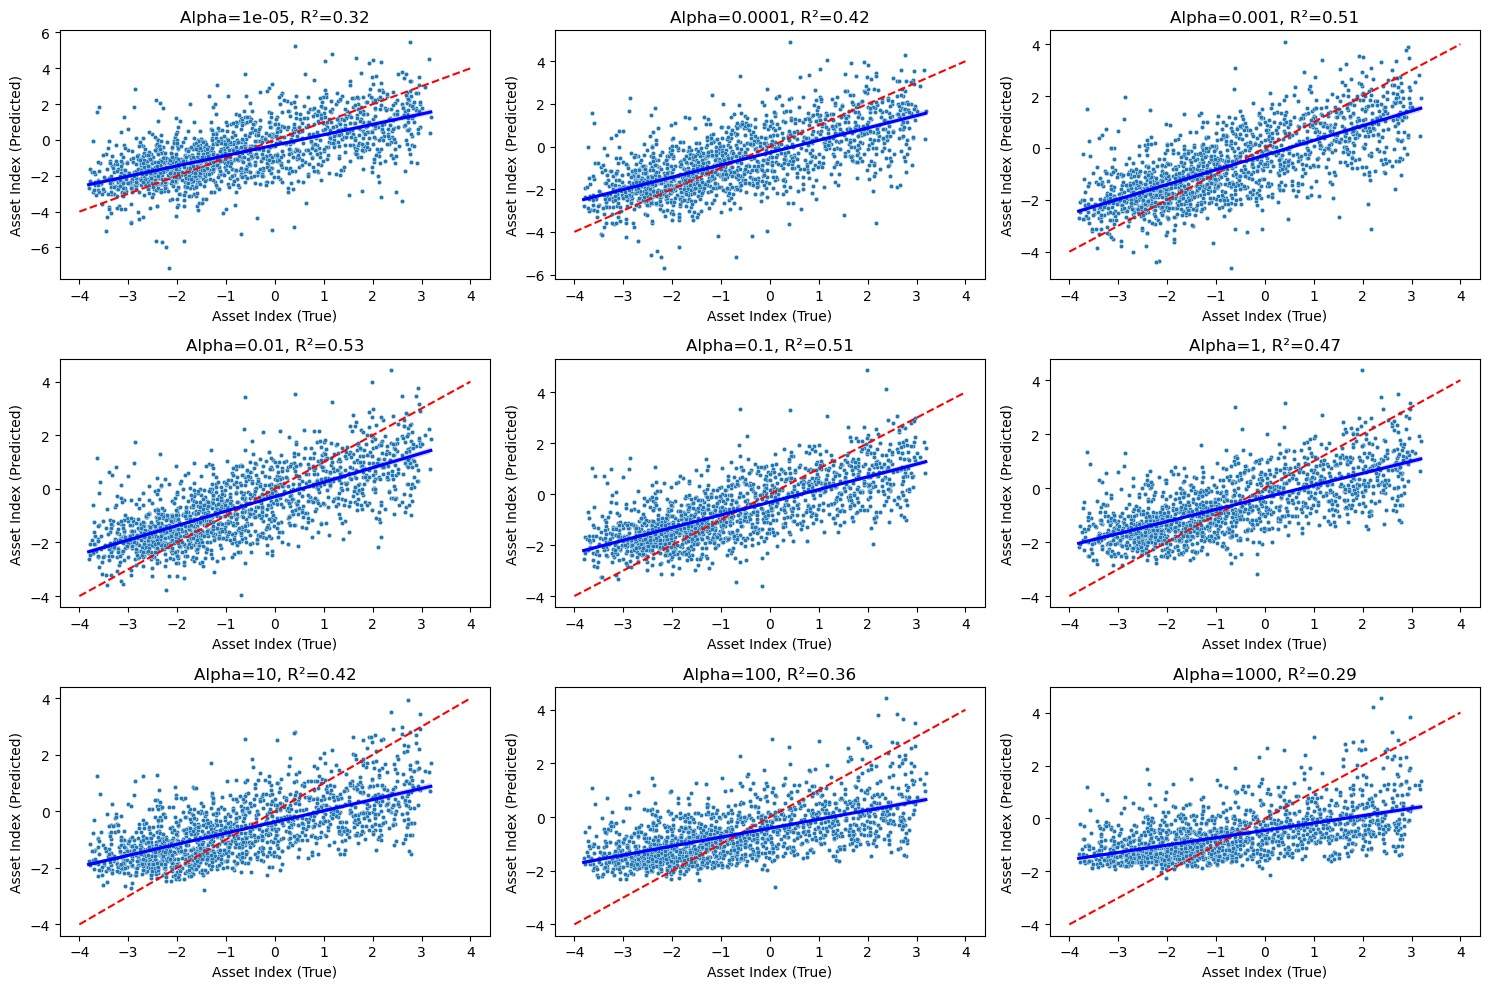

In [114]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Define alpha values to loop over
alpha_values = [10**i for i in range(-5, 4)]  # Corrected alpha values from 0.001 to 1000

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, alpha in enumerate(alpha_values):
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    
    # Create scatter plot using Seaborn
    sns.scatterplot(x=y_val, y=y_pred, ax=axes[i], s=10)
    axes[i].plot([-4, 4], [-4, 4], "r--")  # 45-degree line
    
    # Fit a regression line with confidence interval
    sns.regplot(x=y_val, y=y_pred, ax=axes[i], scatter=False, ci=95, line_kws={"color": "blue"})
    
    axes[i].set_title(f"Alpha={alpha}, R²={r2:.2f}")
    axes[i].set_xlabel("Asset Index (True)")
    axes[i].set_ylabel("Asset Index (Predicted)")

plt.tight_layout()
plt.show()

What do you see happening in the plots above? Answer the following questions:
1. What's going on with the small alpha values? Why are most data points squished up towards the top? Why is there such a strong outlier?
2. What do you think is going on with the large alpha values? Why does the R-squared value decrease again? 
3. The red line shows a 45-degree line of a theoretical perfect fit. The blue line shows an approximation of the actual fit. Why is the blue line consistently flatter than the red line? What does this mean for our model? How could we improve that?

## To Do
- [X] Get the precise embeddings from the MOSAIKS folks
- [X] Work with the 1.0 degrees for now
- [X] Join the MOSAIKS embeddings with the SustainBench data
- [X] Run Ridge regression on the MOSAIKS embeddings with poverty as the label
- [X] Report on the results
- [X] Update the script to work with 0.25 degree tiles
- [ ] Compare with CLAY and SatCLIP